In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd

In [3]:
train_data = pd.read_csv(r"D:\Jupyter\Egyptian_script\train\_annotations.csv")
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2723 entries, 0 to 2722
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  2723 non-null   object
 1   width     2723 non-null   int64 
 2   height    2723 non-null   int64 
 3   class     2723 non-null   object
 4   xmin      2723 non-null   int64 
 5   ymin      2723 non-null   int64 
 6   xmax      2723 non-null   int64 
 7   ymax      2723 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 170.3+ KB


In [4]:
valid_data = pd.read_csv(r"D:\Jupyter\Egyptian_script\valid\_annotations.csv")
test_data = pd.read_csv(r"D:\Jupyter\Egyptian_script\test\_annotations.csv")

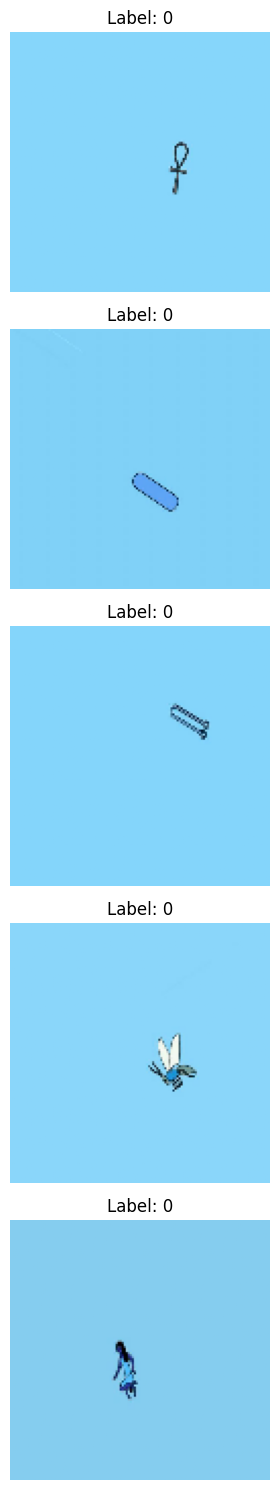

In [5]:
import os
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
import gc
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.preprocessing import OrdinalEncoder

# 数据文件夹路径
train_folder = "D:/Jupyter/Egyptian_script/train/"
valid_folder = "D:/Jupyter/Egyptian_script/valid/"
test_folder = "D:/Jupyter/Egyptian_script/test/"
epoch_num=100
def preprocess_image(image):
    # 调整图像大小
    target_size = (128, 128)
    image = cv2.resize(image, target_size)
    
    # 归一化到0到1之间的范围
    image = image / 255.0
    
    # 转换为PyTorch张量并添加批次维度
    image_tensor = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)
    
    return image_tensor

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        if filename.endswith('.jpg'):
            img = cv2.imread(os.path.join(folder, filename))
            if img is not None:
                preprocessed_img = preprocess_image(img)
                images.append(preprocessed_img)
    return images


train_images = load_images_from_folder(train_folder)
valid_images = load_images_from_folder(valid_folder)
test_images = load_images_from_folder(test_folder)

train_images = torch.cat(train_images, dim=0)
valid_images = torch.cat(valid_images, dim=0)
test_images = torch.cat(test_images, dim=0)

train_labels = train_data['class'].tolist()
valid_labels = valid_data['class'].tolist()
test_labels = test_data['class'].tolist()

train_labels = np.array(train_labels).reshape(-1, 1)
valid_labels = np.array(valid_labels).reshape(-1, 1)
test_labels = np.array(test_labels).reshape(-1, 1)

from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()
encoder.fit(train_labels)
train_labels = encoder.transform(train_labels)
valid_labels = encoder.transform(valid_labels)
test_labels = encoder.transform(test_labels)

train_labels = train_labels.flatten()
valid_labels = valid_labels.flatten()
test_labels = test_labels.flatten()
class_num=len(set(train_labels))

import gc
del(train_data)
del(valid_data)
del(test_data)

gc.collect()

#为检查做准备
train_labels = train_labels.astype(np.int64)

# 获取标签为0的训练图像和对应标签
train_samples = train_images[train_labels == 0]
train_sample_labels = train_labels[train_labels == 0]

num_samples =5

# 创建图像展示区域
fig, axes = plt.subplots(num_samples, 1, figsize=(5, 15))
for i in range(num_samples):
    sample_image = train_samples[i].permute(1, 2, 0).numpy()
    sample_label = train_sample_labels[i]
    axes[i].imshow(sample_image)
    axes[i].set_title(f"Label: {sample_label}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()




In [6]:
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# 将数据转换为 PyTorch 张量

train_labels = torch.tensor(train_labels, dtype=torch.int64)

valid_labels = torch.tensor(valid_labels, dtype=torch.int64)

test_labels = torch.tensor(test_labels, dtype=torch.int64)

# 创建用于训练的 DataLoader
train_dataset = TensorDataset(train_images, train_labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# 创建用于验证的 DataLoader
valid_dataset = TensorDataset(valid_images, valid_labels)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

class InceptionModule(nn.Module):
    def __init__(self, in_channels, out_1x1, out_3x3_reduce, out_3x3, out_5x5_reduce, out_5x5, out_pool):
        super(InceptionModule, self).__init__()
        
        # 1x1 convolution branch
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, out_1x1, kernel_size=1),
            nn.BatchNorm2d(out_1x1),
            nn.ReLU(True)
        )
        
        # 1x1 -> 3x3 convolution branch
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, out_3x3_reduce, kernel_size=1),
            nn.BatchNorm2d(out_3x3_reduce),
            nn.ReLU(True),
            nn.Conv2d(out_3x3_reduce, out_3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_3x3),
            nn.ReLU(True)
        )
        
        # 1x1 -> 5x5 convolution branch
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, out_5x5_reduce, kernel_size=1),
            nn.BatchNorm2d(out_5x5_reduce),
            nn.ReLU(True),
            nn.Conv2d(out_5x5_reduce, out_5x5, kernel_size=5, padding=2),
            nn.BatchNorm2d(out_5x5),
            nn.ReLU(True)
        )
        
        # 3x3 max pooling -> 1x1 convolution branch
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, out_pool, kernel_size=1),
            nn.BatchNorm2d(out_pool),
            nn.ReLU(True)
        )
        
    def forward(self, x):
        return torch.cat([self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)], 1)

class GoogLeNet(nn.Module):
    def __init__(self):
        super(GoogLeNet, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.conv2 = nn.Conv2d(64, 64, kernel_size=1)
        self.conv3 = nn.Conv2d(64, 192, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.inception3a = InceptionModule(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionModule(256, 128, 128, 192, 32, 96, 64)
        
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.inception4a = InceptionModule(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = InceptionModule(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = InceptionModule(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = InceptionModule(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = InceptionModule(528, 256, 160, 320, 32, 128, 128)
        
        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.inception5a = InceptionModule(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = InceptionModule(832, 384, 192, 384, 48, 128, 128)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(1024, class_num)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool1(x)
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.maxpool2(x)
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)
        x = self.inception4a(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        x = self.inception4e(x)
        x = self.maxpool4(x)
        x = self.inception5a(x)
        x = self.inception5b(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# 创建GoogLeNet模型
model = GoogLeNet()

# 打印模型结构
print(model)


GoogLeNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  (conv3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (inception3a): InceptionModule(
    (branch1): Sequential(
      (0): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (branch2): Sequential(
      (0): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affin

In [7]:
# ... 在这之前是模型定义部分 ...
from sklearn.model_selection import KFold

# 将数据移到GPU上
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_images = train_images.to(device)
train_labels = train_labels.to(device)
valid_images = valid_images.to(device)
valid_labels = valid_labels.to(device)
test_images = test_images.to(device)
test_labels = test_labels.to(device)

# 创建用于训练的 DataLoader
train_dataset = TensorDataset(train_images, train_labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 创建用于验证的 DataLoader
valid_dataset = TensorDataset(valid_images, valid_labels)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

# ...（模型定义部分）...

# 定义交叉验证折数
num_folds = 5

# 创建交叉验证对象
kf = KFold(n_splits=num_folds)

# 定义损失函数
criterion = nn.CrossEntropyLoss()

# 定义学习率
learning_rate = 0.01

# 存储每次交叉验证的验证损失和准确率
val_losses = []
val_accuracies = []

# 进行交叉验证
for fold, (train_index, val_index) in enumerate(kf.split(train_dataset)):
    print(f"交叉验证 折数：{fold + 1}")
    
    # 划分训练集和验证集
    train_subset = torch.utils.data.Subset(train_dataset, train_index)
    val_subset = torch.utils.data.Subset(train_dataset, val_index)
    
    # 创建 DataLoader
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
    model.to(device)  # 将模型移到GPU上

    
    # 创建优化器，同时设置学习率
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # 存储训练历史数据
    history = {
        'loss': [],
        'val_loss': [],
        'accuracy': [],
        'val_accuracy': []
    }
    
    # 训练循环
    for epoch in range(epoch_num):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
        
        # 计算训练准确率
        train_accuracy = correct_predictions / total_predictions
        
        # 在验证集上评估模型
        model.eval()
        val_loss = 0.0
        correct_predictions_val = 0
        total_predictions_val = 0
        with torch.no_grad():
            for inputs_val, labels_val in val_loader:
                inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
                outputs_val = model(inputs_val)
                loss_val = criterion(outputs_val, labels_val)
                val_loss += loss_val.item()

                _, predicted_val = torch.max(outputs_val, 1)
                total_predictions_val += labels_val.size(0)
                correct_predictions_val += (predicted_val == labels_val).sum().item()

        val_accuracy = correct_predictions_val / total_predictions_val
        val_loss /= len(val_loader)
        
        # 将当前 epoch 的训练和验证数据记录到 history 字典中
        history['loss'].append(running_loss / len(train_loader))
        history['accuracy'].append(train_accuracy)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)
        
        print(f"第 {epoch+1} 轮，训练损失：{running_loss / len(train_loader)}, 训练准确率：{train_accuracy}")
        print(f"第 {epoch+1} 轮，验证损失：{val_loss}, 验证准确率：{val_accuracy}")
    
    # 将验证损失和准确率存储到对应的列表中
    val_losses.append(history['val_loss'])
    val_accuracies.append(history['val_accuracy'])

# 计算交叉验证的平均验证损失和准确率
avg_val_losses = np.mean(val_losses, axis=0)
avg_val_accuracies = np.mean(val_accuracies, axis=0)

print("交叉验证结果：")
for fold in range(num_folds):
    print(f"折数 {fold+1}，平均验证损失：{avg_val_losses[fold]}, 平均验证准确率：{avg_val_accuracies[fold]}")

# 在测试数据上进行评估
model.eval()
with torch.no_grad():
    test_outputs = model(test_images)
    _, predicted = torch.max(test_outputs, 1)
    correct = (predicted == test_labels).sum().item()
    total = test_labels.size(0)
    accuracy = correct / total
    print(f"测试准确率：{accuracy}")

交叉验证 折数：1
第 1 轮，训练损失：5.20526803749195, 训练准确率：0.013314967860422406
第 1 轮，验证损失：5.714591926998562, 验证准确率：0.011009174311926606
第 2 轮，训练损失：4.57936409936435, 训练准确率：0.011019283746556474
第 2 轮，验证损失：4.601535585191515, 验证准确率：0.003669724770642202


KeyboardInterrupt: 

In [ ]:
# 绘制学习曲线
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(20, 15))
axs[0, 0].plot(history['loss'], label='Training Loss')
axs[0, 0].plot(history['val_loss'], label='Validation Loss')
axs[0, 0].set_title('CustomCNN Learning Curve')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].legend()

axs[0, 1].plot(history['accuracy'], label='Training Accuracy')
axs[0, 1].plot(history['val_accuracy'], label='Validation Accuracy')
axs[0, 1].set_title('CustomCNN Accuracy Curve')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Accuracy')
axs[0, 1].legend()

plt.tight_layout()
plt.show()